In [2]:
!rm -r DD-GAN-AE
!git clone https://github.com/acse-zrw20/DD-GAN-AE

rm: cannot remove 'DD-GAN-AE': No such file or directory
Cloning into 'DD-GAN-AE'...
remote: Enumerating objects: 1531, done.
remote: Counting objects: 100% (476/476), done.
remote: Compressing objects: 100% (334/334), done.
remote: Total 1531 (delta 328), reused 281 (delta 142), pack-reused 1055
Receiving objects: 100% (1531/1531), 50.49 MiB | 10.46 MiB/s, done.
Resolving deltas: 100% (957/957), done.


In [3]:
!pip install ./DD-GAN-AE/
!pip install wandb
!pip install vtk

Processing ./DD-GAN-AE
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for DD-GAN-AE: filename=DD_GAN_AE-1.0-py3-none-any.whl size=230465 sha256=ecab49c00685dbadbeb51ed74a54f4483704d354fbb4bf711cffc2a70378ad09
  Stored in directory: /root/.cache/pip/wheels/45/3e/c9/0f8d36efdb30e4fd5fe4fc03ed5470c1121548319232fd1842
Successfully built DD-GAN-AE
     |████████████████████████████████| 1.6 MB 8.6 MB/s 
     |████████████████████████████████| 97 kB 7.9 MB/s 
     |████████████████████████████████| 170 kB 51.3 MB/s 
     |████████████████████████████████| 133 kB 64.3 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Cre

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import wandb
import tensorflow as tf
import keras
from ddganAE.models import Predictive_adversarial, Predictive
from ddganAE.architectures.svdae import *
from ddganAE.architectures.cae.D3 import *
from ddganAE.architectures.discriminators import *
from ddganAE.wandb.train_wandb_pred import train_wandb_pred_aae, train_wandb_pred_ae
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [13]:
# Configuration options for hyperparameter optimization
Predictive_adversarial_sweep_config = {
    "method": "bayes",
    "metric": {"name": "prediction_mse", "goal": "minimize"},
    "parameters": {
        "architecture": {
            "values": [
                "dense",
                "deeper_dense",
                "wider_dense",
                "slimmer_dense",
                "vinicius",
                "smaller_vinicius",
                "slimmer_vinicius",
            ]
        },
        "activation": {"values": ["relu", "elu", "sigmoid", "tanh"]},
        "discriminator_architecture": {"values": ["custom", "custom_wider"]},
        "in_vars": {"values": [10]},
        "dense_activation": {"values": ["relu", "linear"]},
        "batch_size": {"values": [32, 64, 128]},
        "learning_rate": {"values": [5e-3, 5e-4, 5e-5]},
        "dropout": {"values": [0.3, 0.55, 0.8]},
        "optimizer": {"values": ["nadam", "adam", "sgd"]},
        "momentum": {"values": [0.8, 0.9, 0.98]},
        "beta_2": {"values": [0.9, 0.999, 0.99999]},
        "batch_normalization": {"values": [True, False]},
        "regularization": {"values": [1e-4, 1e-5, 1e-6, 0]},
        "savemodel": {"values": [False]},
        "latent_vars": {"values": [50]},
        "interval": {"values": [1, 2, 5, 10]},
        "final_act": {
            "values": [
              "linear",
              "sigmoid",
              "tanh"
            ]
        },
        "noise_std": {"values": [0.001, 0.01, 0.05, 0.1]},
        "increment": {"values": [True, False]},
        "epochs": {"values": [200, 500, 1000, 2000]},
        "n_discriminator": {"values": [1, 2, 4, 5]},
        "n_gradient_ascent": {"values": [3, 8, 15, 30]},
        "domains": {"values": [10]}
    },
}

# Configuration options for hyperparameter optimization
Predictive_adversarial_sweep_config_opt = {
    "method": "random",
    "metric": {"name": "valid_loss", "goal": "minimize"},
    "parameters": {
        "architecture": {
            "values": [
                "slimmer_dense"
            ]
        },
        "activation": {"values": ["relu"]},
        "discriminator_architecture": {"values": ["custom"]},
        "in_vars": {"values": [20]},
        "dense_activation": {"values": ["linear"]},
        "batch_size": {"values": [128]},
        "learning_rate": {"values": [0.00005]},
        "dropout": {"values": [0.3]},
        "optimizer": {"values": ["nadam"]},
        "momentum": {"values": [0.9]},
        "beta_2": {"values": [0.9]},
        "batch_normalization": {"values": [False]},
        "regularization": {"values": [0.000001]},
        "savemodel": {"values": [True]},
        "latent_vars": {"values": [60]},
        "interval": {"values": [6]},
        "final_act": {
            "values": [
              "linear"
            ]
        },
        "noise_std": {"values": [0.01]},
        "increment": {"values": [False]},
        "epochs": {"values": [1000]},
        "n_discriminator": {"values": [1]},
        "n_gradient_ascent": {"values": [15]},
        "domains": {"values": [10]}
    },
}

# Configuration options for hyperparameter optimization
Predictive_ae_sweep_config_opt = {
    "method": "random",
    "metric": {"name": "prediction_mse", "goal": "minimize"},
    "parameters": {
        "architecture": {
            "values": [
                "wider_dense"
            ]
        },
        "activation": {"values": ["relu"]},
        "in_vars": {"values": [20]},
        "dense_activation": {"values": ["linear"]},
        "batch_size": {"values": [32]},
        "learning_rate": {"values": [0.00005]},
        "dropout": {"values": [0.3]},
        "optimizer": {"values": ["nadam"]},
        "momentum": {"values": [0.98]},
        "beta_2": {"values": [0.999]},
        "batch_normalization": {"values": [False]},
        "regularization": {"values": [0.001]},
        "savemodel": {"values": [True]},
        "latent_vars": {"values": [30]},
        "interval": {"values": [6]},
        "final_act": {
            "values": [
              "linear"
            ]
        },
        "noise_std": {"values": [0.00001]},
        "increment": {"values": [False]},
        "epochs": {"values": [500]},
        "domains": {"values": [10]}
    },
}

Predictive_adversarial_sweep_config['parameters']['datafile'] = {'values': ["/content/drive/MyDrive/Colab Notebooks/data/cae_latent_sf_10vars_800steps_different.npy"]}
Predictive_adversarial_sweep_config['parameters']['datafile'] = {'values': ["/content/drive/MyDrive/Colab Notebooks/data/cae_latent_sf_10vars_800steps_different.npy"]}
#Predictive_adversarial_sweep_config_opt['parameters']['datafile'] = {'values': ["/content/drive/MyDrive/Colab Notebooks/data/cae_latent_sf_10vars_800steps_different.npy"]}
#Predictive_adversarial_sweep_config_opt['parameters']['datafile'] = {'values': ["/content/drive/MyDrive/Colab Notebooks/data/cae_latent_sf_100vars_800steps_restful.npy"]}
Predictive_ae_sweep_config_opt['parameters']['datafile'] = {'values': ["/content/drive/MyDrive/Colab Notebooks/data/aae_latent_sf_20vars_800steps_gallant.npy"]}

sweep_id = wandb.sweep(Predictive_ae_sweep_config_opt, project='pred-ae',
                          entity='zeff020')
wandb.agent(sweep_id, train_wandb_pred_ae, count=1)

Create sweep with ID: k67xbozb
Sweep URL: https://wandb.ai/zeff020/pred-ae/sweeps/k67xbozb


wandb: Agent Starting Run: kr07urz4 with config:
wandb: 	activation: relu
wandb: 	architecture: wider_dense
wandb: 	batch_normalization: False
wandb: 	batch_size: 32
wandb: 	beta_2: 0.999
wandb: 	datafile: /content/drive/MyDrive/Colab Notebooks/data/aae_latent_sf_20vars_800steps_gallant.npy
wandb: 	dense_activation: linear
wandb: 	domains: 10
wandb: 	dropout: 0.3
wandb: 	epochs: 500
wandb: 	final_act: linear
wandb: 	in_vars: 20
wandb: 	increment: False
wandb: 	interval: 6
wandb: 	latent_vars: 30
wandb: 	learning_rate: 5e-05
wandb: 	momentum: 0.98
wandb: 	noise_std: 1e-05
wandb: 	optimizer: nadam
wandb: 	regularization: 0.001
wandb: 	savemodel: True


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


INFO:tensorflow:Assets written to: model_glamorous-sweep-1/encoder/assets
INFO:tensorflow:Assets written to: model_glamorous-sweep-1/decoder/assets


epoch,499
train_loss,0.00025
train_accuracy,0.95784
valid_loss,0.00012
valid_accuracy,0.9707
_runtime,1135
_timestamp,1628851055
_step,500
prediction_mse,9e-05


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
valid_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_accuracy,▁▁▃▃▄▅▅██▆▇███▆▇▇▇▇▇▇▇█▇█▇█▇▇▇███▇█▇▇▇▇█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
prediction_mse,▁


In [ ]:
!mv ./model_* "/content/drive/MyDrive/Colab Notebooks"

In [ ]:
latent_vars = np.load("/content/drive/MyDrive/Colab Notebooks/data/cae_latent_sf_10vars_1705steps_different.npy")

In [ ]:
latent_vars.shape

(17050, 10)

# The below cells are for making actual predictions

In [ ]:
# Data processing
latent_vars = np.load("/content/drive/MyDrive/Colab Notebooks/data/cae_latent_sf_10vars_800steps_different.npy")

latent_vars_reshaped = np.moveaxis(latent_vars.reshape(800, 10, 10),
                                    0, 2)

train_data = latent_vars_reshaped[:]

# Scaling the latent variables
scaler = MinMaxScaler((-1, 1))
train_data = scaler.fit_transform(
  train_data.reshape(-1, 1)).reshape(train_data.shape)

In [ ]:
# Create boundaries and initial values arrays for prediction later
boundaries = np.zeros((2, 10, 800))
boundaries[0] = train_data[2]
boundaries[1] = train_data[9]


init_values = np.zeros((12, 10))
init_values[:] = np.repeat(train_data[3:9, :, 0], 2, axis=0)

In [ ]:
# Create boundaries and initial values arrays for prediction later
boundaries = np.zeros((2, 10, 800))
boundaries[0] = train_data[2]
boundaries[1] = train_data[9]


init_values = np.zeros((96, 10))
init_values[:] = np.repeat(train_data[3:9, :, 0], 16, axis=0)

In [ ]:
# This is for predicting further into the future
boundaries = np.zeros((2, 10, 1200))
boundaries[0, :, :800] = train_data[2]
boundaries[1, :, :800] = train_data[9]

# Here we pick a particular inlet, this one is one with steady flow (half blue,
# half red). Produces a steady state in the subsequent domains
boundaries[:, :, 800:] = np.repeat(boundaries[:, :, ::6][:, :, 125:126], 400, axis=2)

init_values = np.zeros((96, 10))
init_values[:] = np.repeat(train_data[3:9, :, 0], 16, axis=0)

In [ ]:
# This is for predicting further into the future with a changing boundary, 
# repeating an earlier value
boundaries = np.zeros((2, 10, 194))
boundaries[0, :, :134] = train_data[2, :, ::6]
boundaries[1, :, :134] = train_data[9, :, ::6]

# Here we pick a particular inlet, this one is one with steady flow (half blue,
# half red). Produces a steady state in the subsequent domains
boundaries[1, :, 134:] = np.repeat(boundaries[1:2, :, :][:, :, 125:126], 60, axis=2)
boundaries[0, :, 134:] = np.tile(np.concatenate((boundaries[0, :, 125:134], boundaries[0, :, 125:126]), axis=-1), (1,1,6))

init_values = np.zeros((12, 10))
init_values[:] = np.repeat(train_data[3:9, :, 0], 2, axis=0)

In [ ]:
# This is for predicting further into the future with a random noise boundary


In [ ]:
latent_vars = np.load("/content/drive/MyDrive/Colab Notebooks/latent_vars.npy")

In [ ]:

latent_vars = np.expand_dims(np.swapaxes(latent_vars, 0, 1), 0)
#latent_vars = scaler.fit_transform(
#  latent_vars.reshape(-1, 1)).reshape(latent_vars.shape)

In [ ]:
latent_vars.shape

(1, 10, 60)

In [ ]:
boundaries = np.zeros((2, 10, 194))
boundaries[0, :, :134] = train_data[2, :, ::6]
boundaries[1, :, :134] = train_data[9, :, ::6]

# Here we pick a particular inlet, this one is one with steady flow (half blue,
# half red). Produces a steady state in the subsequent domains
boundaries[1, :, 134:] = np.repeat(boundaries[1:2, :, :][:, :, 125:126], 60, axis=2)
boundaries[0, :, 134:] = latent_vars[0, :, ::1][:, :60]

init_values = np.zeros((12, 10))
init_values[:] = np.repeat(train_data[3:9, :, 0], 2, axis=0)

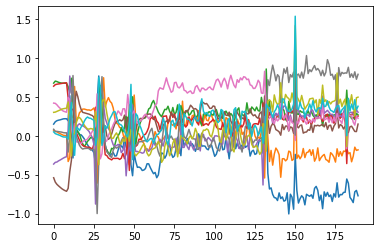

In [ ]:
plt.plot(boundaries[0, :, 0:190:].T)
train_point_1 = train_data[1:4, :, 125*6:134*6][:, :, 0]
train_point_2 = train_data[1:4, :, 125*6:134*6][:, :, 34]
train_point_3 = train_data[1:4, :, 125*6:134*6][:, :, 42]

In [ ]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.98, beta_2=0.99999)

vars_latent = 100
nPOD = 10

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#encoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/pred_aae_model_northern-sweep-1-5int/encoder") 
#decoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/pred_aae_model_northern-sweep-1-5int/decoder")
#discriminator = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/aae_model_mild-sweep-1/discriminator")

encoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/cae_pred_model_clear-sweep-1-6int/encoder") 
decoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/cae_pred_model_clear-sweep-1-6int/decoder")
discriminator =  discriminator = build_custom_wider_discriminator(
                vars_latent, initializer, info=True
            )
discriminator._name = "NAME"

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              101000    
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 1,103,001
Trainable params: 1,103,001
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
pred_adv = Predictive_adversarial(encoder, decoder, discriminator, optimizer)
pred_adv.compile(nPOD)

In [ ]:
pred_adv.interval = 6

In [ ]:
predicted = pred_adv.predict(boundaries, init_values, 100, iters=3, sor=1, pre_interval=False)

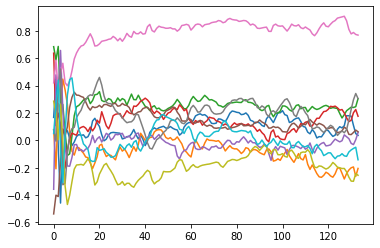

In [ ]:
plt.plot(train_data[0, :, ::6].T)

In [ ]:
predicted = scaler.inverse_transform(
  predicted.reshape(-1, 1)).reshape(predicted.shape)

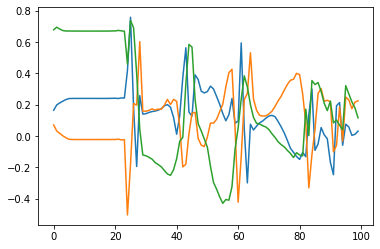

In [ ]:
plt.plot(predicted[3, :3, :100].T)

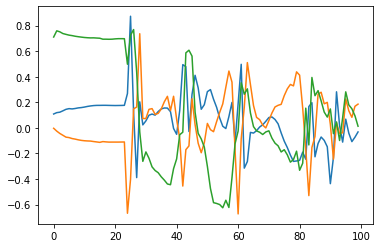

In [ ]:
plt.plot(latent_vars_reshaped[5, :3, :100*6:6].T)

In [ ]:
latent_decoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/cae_model_different-sweep-1/decoder")

In [ ]:
predicted_10doms = predicted_interpolated[0:10, :, 80:125]

In [ ]:

out_reshaped = np.moveaxis(predicted_10doms, 2, 0).reshape(450, 10)

In [ ]:
out_grids = latent_decoder.predict(out_reshaped)

In [ ]:
out_grids.shape

(450, 60, 20, 20, 4)

In [ ]:
np.save("out_grids", out_grids)

In [ ]:
from scipy import interpolate


In [ ]:
predicted_interpolated = np.zeros((10, 10, 198))

for i in range(10):
  f = interpolate.interp1d(np.arange(0, 100), predicted[i, :, :100])
  xnew = np.arange(0, 99, 0.50)
  predicted_interpolated[i, :, :] = f(xnew)

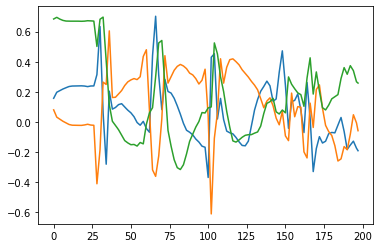

In [ ]:
plt.plot(predicted_interpolated[1, :3, :198].T)

In [ ]:
config.activation = "elu"
config.in_vars = 100
config.dense_activation = "relu" 
config.batch_size = 64 
config.learning_rate = 0.0005
config.architecture = "slimmer_vinicius"
config.discriminator_architecture = "custom"
config.dropout = 0.3
config.optimizer = "adam"
config.momentum = 0.8
config.beta_2 = 0.9
config.batch_normalization = True
config.regularization = 0.001
config.savemodel = True
config.latent_vars = 100
config.interval = 6
config.final_act = "sigmoid"
config.noise_std = 0.01
config.increment = False
config.epochs = 2
config.n_discriminator = 1
config.n_gradient_ascent = 15
config.domains = 10
config.datafile = "/content/drive/MyDrive/Colab Notebooks/data/cae_latent_sf_100vars_800steps_restful.npy"